# 🔧 Feature Engineering and Selection for IBM HR Analytics: Employee Attrition & Performance 

## Importing Dependencies

In [1]:
import sys
import os
import warnings

warnings.filterwarnings("ignore")
sys.path.append(os.path.abspath(os.path.join("..", "scripts", "utils")))

%matplotlib inline
import pandas as pd
import numpy as np
from scipy.stats import boxcox, mstats
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Utils
import visualization as viz
from data_helpers import get_cols_names, print_cols_summary

In [2]:
DATA_PATH = os.path.join("..", "data", "raw", "hr_employee_attrition.csv")

# Setting parameters
pd.set_option("display.max_columns", 60)
pd.set_option("display.max_rows", 60)
pd.set_option("display.float_format", lambda x: f"{x:.2f}")

mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

plt.style.use("ggplot")
sns.set_style("darkgrid", {"grid.color": ".8"})

## Data Loading

In [3]:
df = pd.read_csv(DATA_PATH)
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [4]:
cat_cols, num_cols, num_but_cat_cols, cat_but_car_cols = get_cols_names(df)
features_to_remove = []  # We'll add redundant features step by step to this list to remove them later
target_col = "Attrition"

## Adding New features

In [5]:
new_df = df.copy()

In [6]:
new_df["NEW_IncomeStability"] = new_df["MonthlyIncome"] / new_df["MonthlyRate"]
new_df["NEW_OvertimeImpact"] = (new_df["OverTime"] == "Yes").astype(int) * new_df["JobSatisfaction"]
new_df["NEW_AttritionRiskScore"] = (
  (new_df["OverTime"] == "Yes").astype(int) * 2 + 
  (4 - new_df["JobSatisfaction"]) + 
  (4 - new_df["WorkLifeBalance"]) + 
  (new_df["YearsSinceLastPromotion"] > 5).astype(int) * 2
)
new_df["NEW_FirstJob"] = (new_df["NumCompaniesWorked"] == 0).astype(int)
new_df["NEW_FrequentTraveler"] = new_df["BusinessTravel"].apply(lambda x: 1 if x == "Travel_Frequently" else 0)
new_df["NEW_MarriedWithHighWorkload"] = ((new_df["MaritalStatus"] == "Married") & (new_df["OverTime"] == "Yes")).astype(int)

In [7]:
cat_cols, num_cols, num_but_cat_cols, cat_but_car_cols = get_cols_names(new_df)
print_cols_summary(new_df, cat_cols, num_cols, num_but_cat_cols, cat_but_car_cols)

Categorical columns (27) (including numeric-looking categorical columns): ['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime', 'Education', 'EmployeeCount', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'NumCompaniesWorked', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TrainingTimesLastYear', 'WorkLifeBalance', 'NEW_OvertimeImpact', 'NEW_AttritionRiskScore', 'NEW_FirstJob', 'NEW_FrequentTraveler', 'NEW_MarriedWithHighWorkload']

From them numeric-looking categorical columns (18): ['Education', 'EmployeeCount', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'NumCompaniesWorked', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TrainingTimesLastYear', 'WorkLifeBalance', 'NEW_OvertimeImpact', 'NEW_AttritionRiskScore', 'NEW_FirstJob', 'NEW_FrequentTraveler', 'NEW_MarriedWithHighWorkl

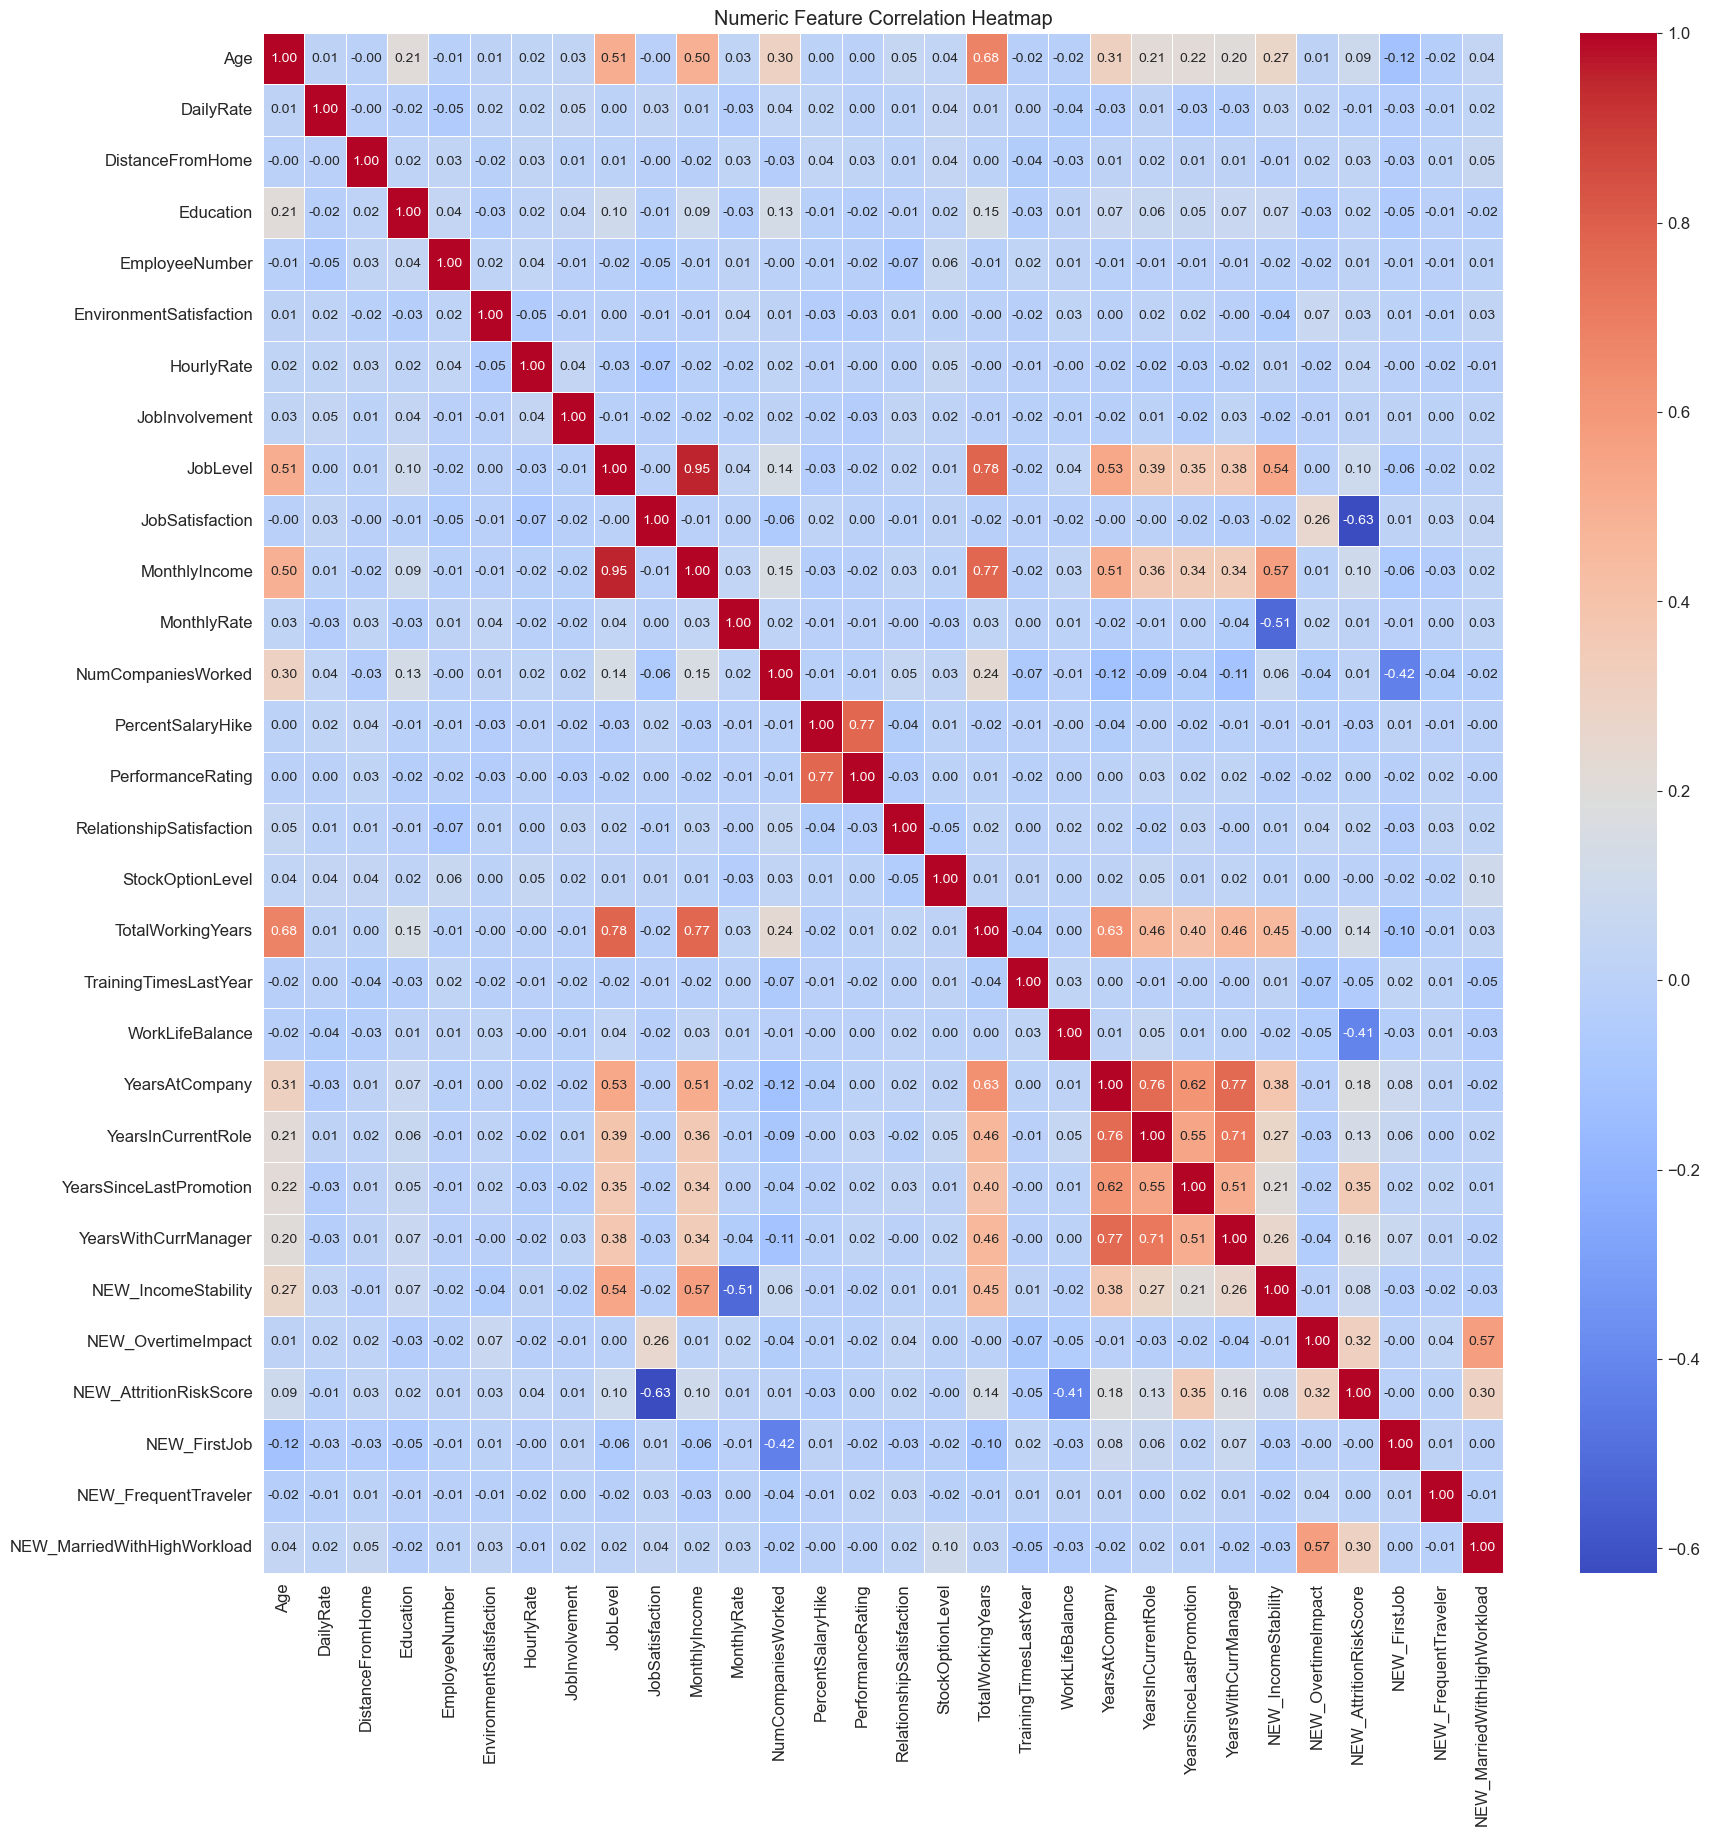

In [8]:
plt.figure(figsize=(20, 20))
sns.heatmap(new_df.drop(columns=["EmployeeCount", "StandardHours"]).corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Numeric Feature Correlation Heatmap")
plt.show()

### Removing Highly Correlated Features

In [9]:
corr_th = 0.85
corr = new_df.corr(numeric_only=True)
cor_matrix = corr.abs()
upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))

highly_correlated_features = set()
for col in upper_triangle_matrix.columns:
  if any(upper_triangle_matrix[col] > corr_th):
    highly_correlated_features.add(col)

print(list(highly_correlated_features))
features_to_remove.extend(list(highly_correlated_features))
new_df.drop(columns=list(highly_correlated_features), inplace=True)

['MonthlyIncome']


## Winsorization & Log Transformation to Handle Outliers and Fix Skewness

We apply **log transformation** and **winsorization** to the features that have high skewness to handle **outliers** and fix **skewness**.

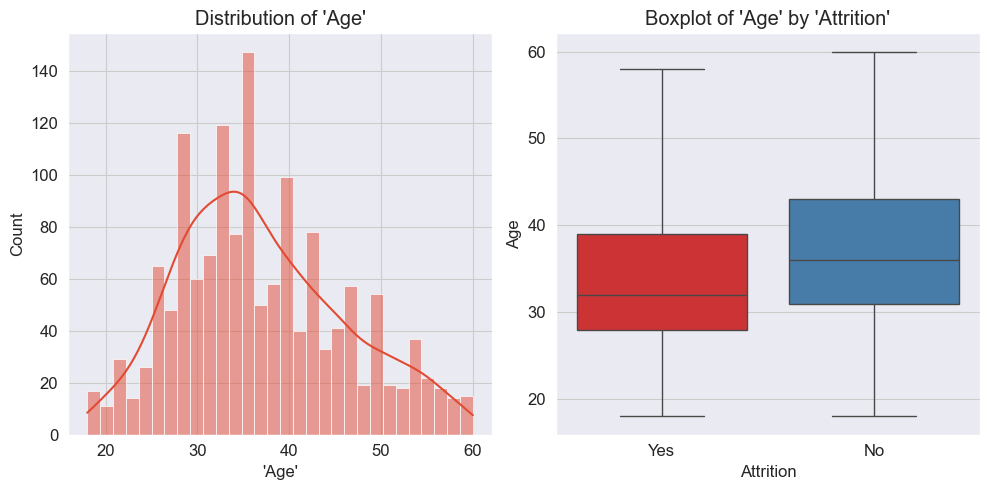

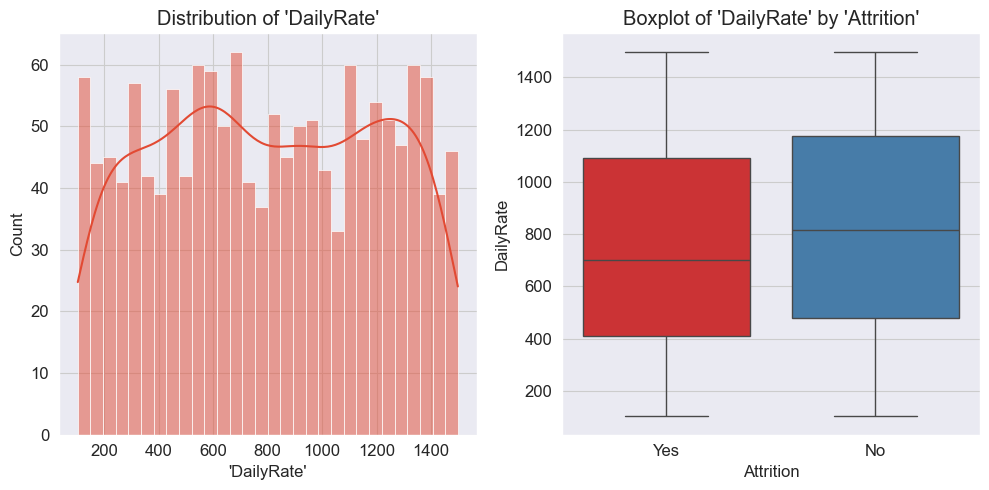

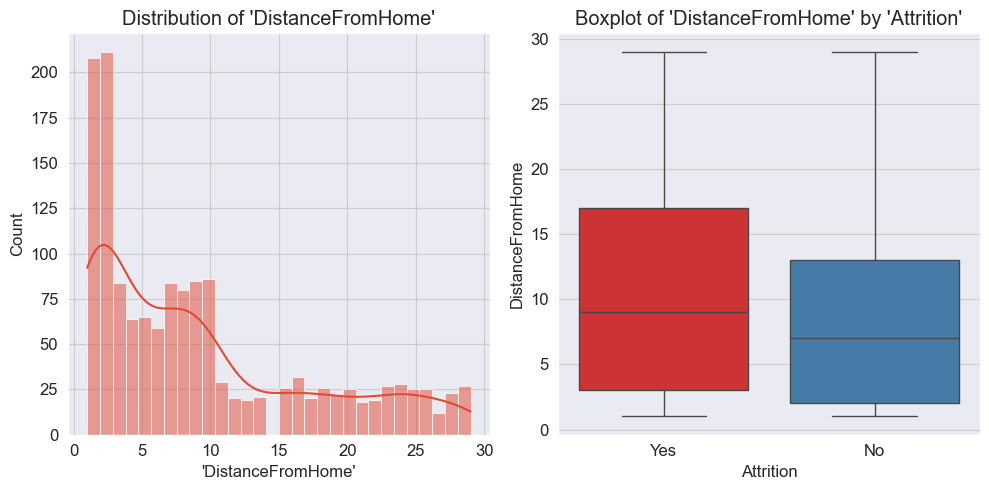

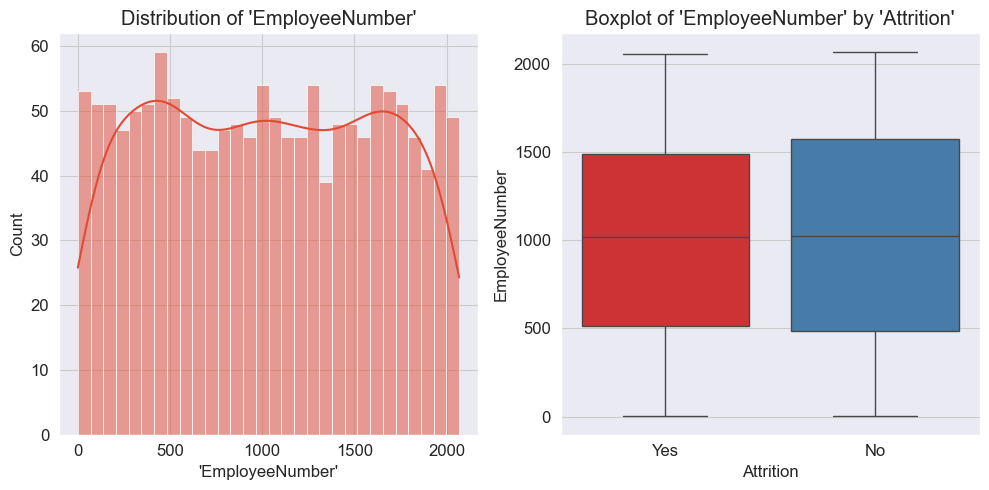

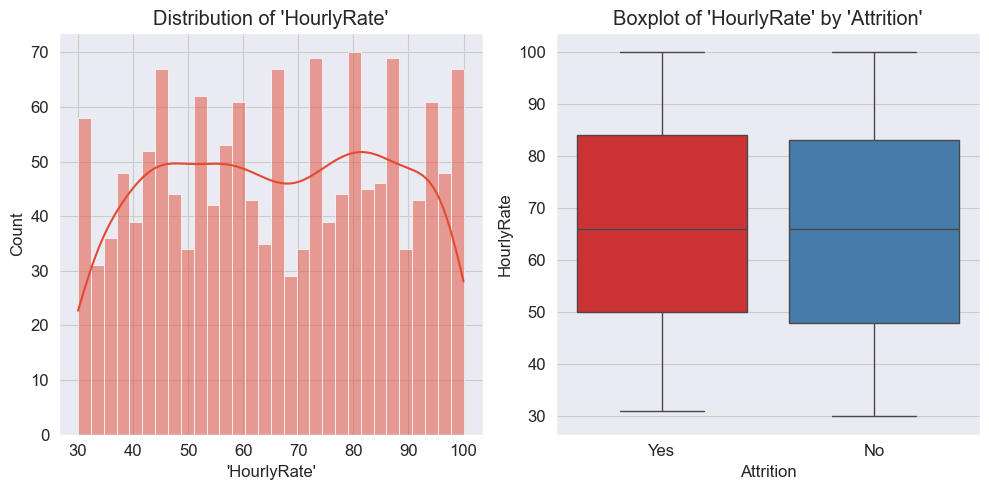

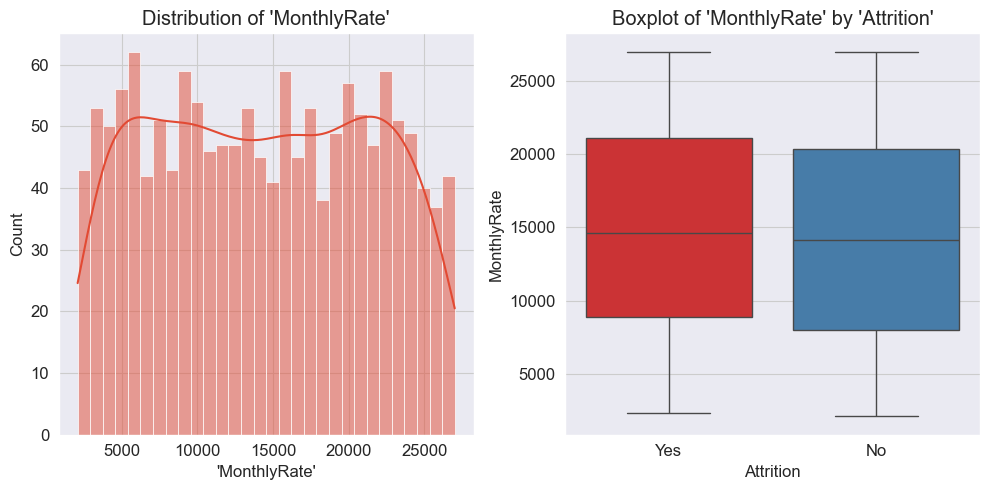

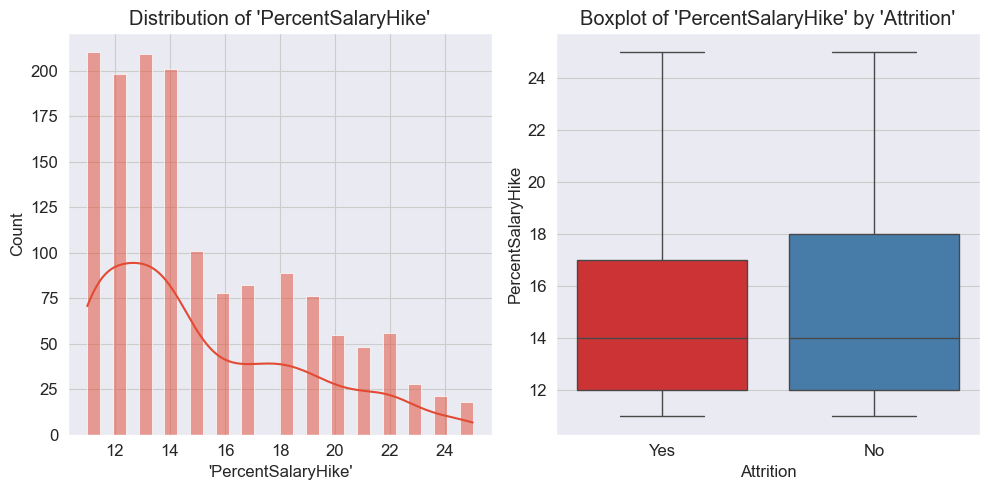

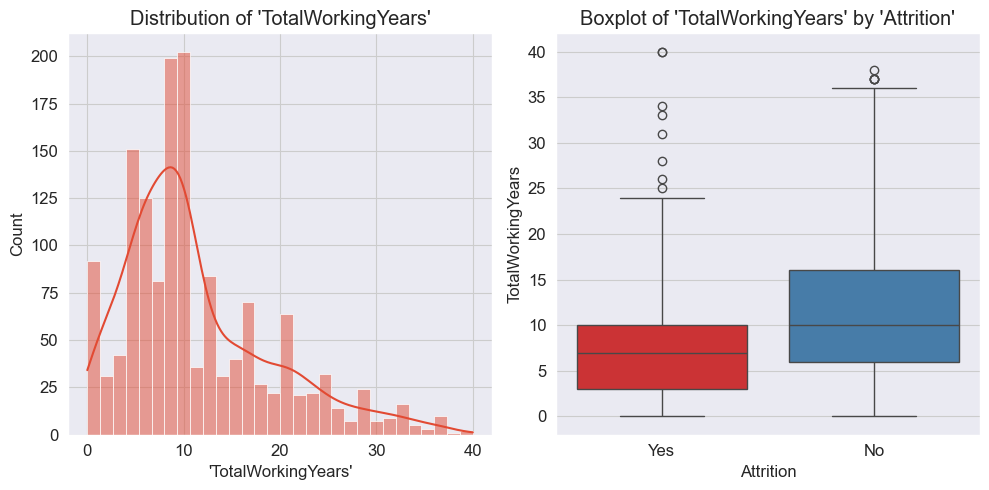

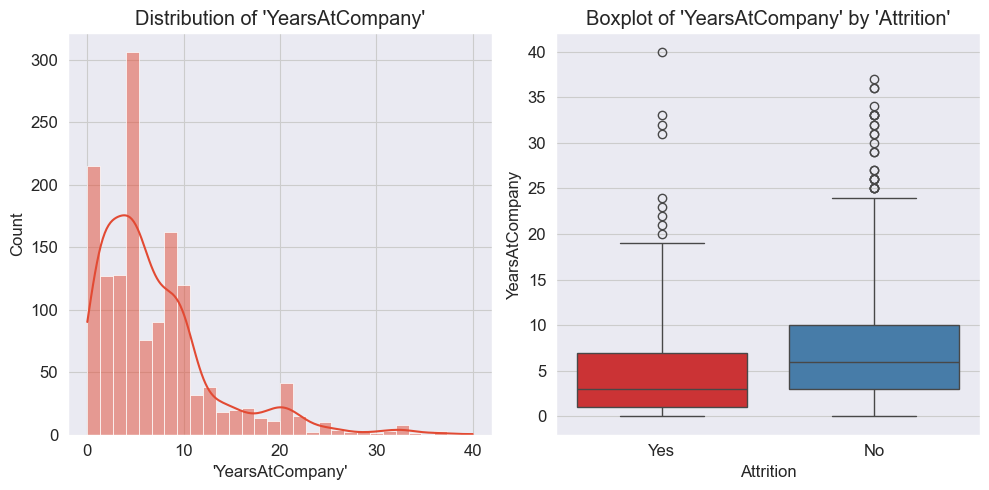

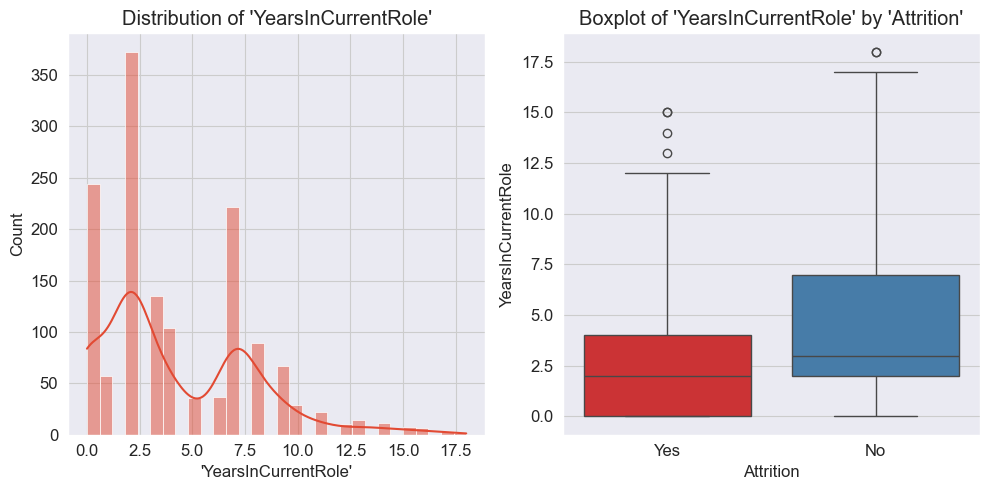

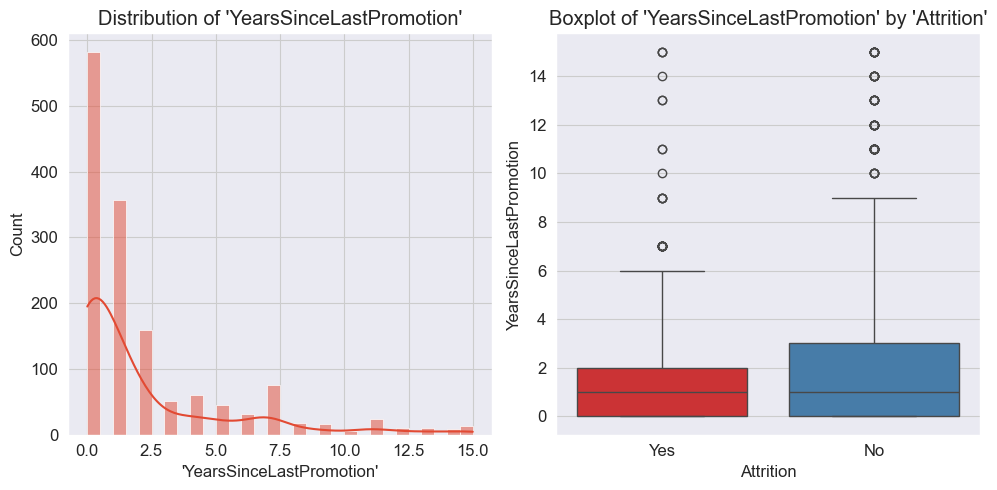

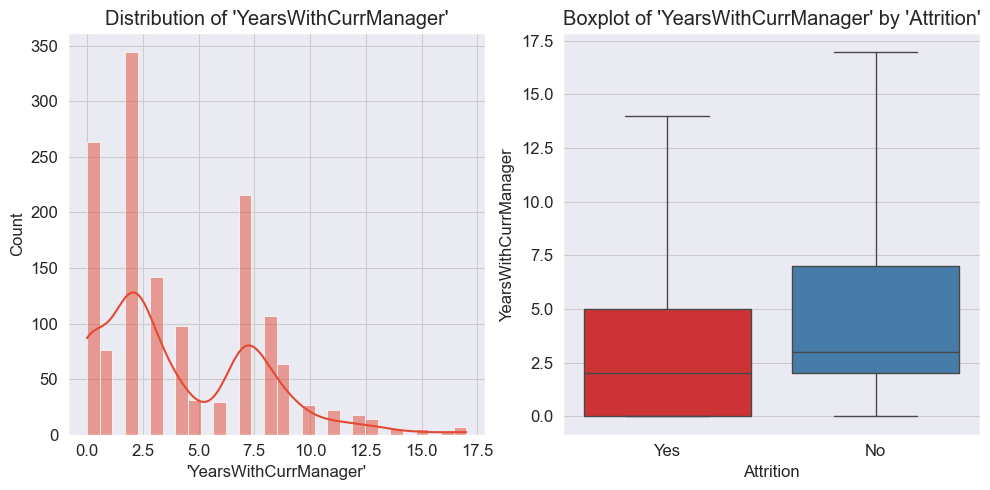

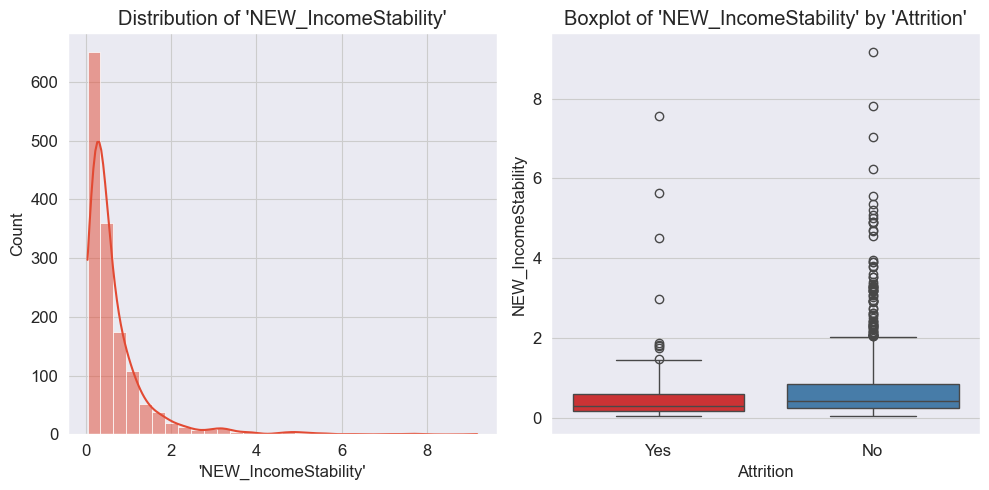

In [10]:
num_cols = [col for col in num_cols if col not in features_to_remove]

for col in num_cols:
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  viz.num_distribution(new_df, col_name=col, ax=axes[0])
  viz.boxplot_by_target(new_df, target_col, col, ax=axes[1])

  plt.tight_layout()
  plt.show()

In [11]:
cols_with_high_skew = [col for col in num_cols if new_df[col].skew() > 0.7 ]

# Winsorization & Log Transformation to reduce skewness
for col in cols_with_high_skew:
  print(f"\nColumn: {col}")
  print("Original Skewness:", new_df[col].skew())
  
  new_df[col] = mstats.winsorize(new_df[col], limits=[0.01, 0.01]) 
  new_df[col] = np.log1p(new_df[col]) 

  print("Log Transformed Skewness after winsorization:", new_df[col].skew())


Column: DistanceFromHome
Original Skewness: 0.9581179956568269
Log Transformed Skewness after winsorization: -0.029120785364396513

Column: PercentSalaryHike
Original Skewness: 0.8211279755780908
Log Transformed Skewness after winsorization: 0.5135425214775441

Column: TotalWorkingYears
Original Skewness: 1.1171718528128527
Log Transformed Skewness after winsorization: -0.5070181582668091

Column: YearsAtCompany
Original Skewness: 1.7645294543422085
Log Transformed Skewness after winsorization: -0.22286218323009538

Column: YearsInCurrentRole
Original Skewness: 0.9173631562908262
Log Transformed Skewness after winsorization: -0.3932633576146813

Column: YearsSinceLastPromotion
Original Skewness: 1.9842899833524859
Log Transformed Skewness after winsorization: 0.7122359740239425

Column: YearsWithCurrManager
Original Skewness: 0.8334509919918475
Log Transformed Skewness after winsorization: -0.37099110584625594

Column: NEW_IncomeStability
Original Skewness: 4.026869099136869
Log Trans

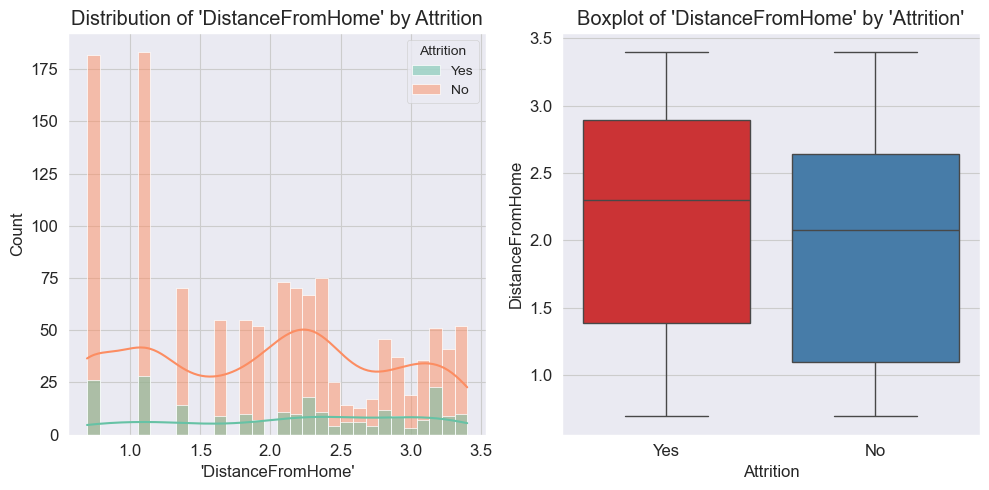

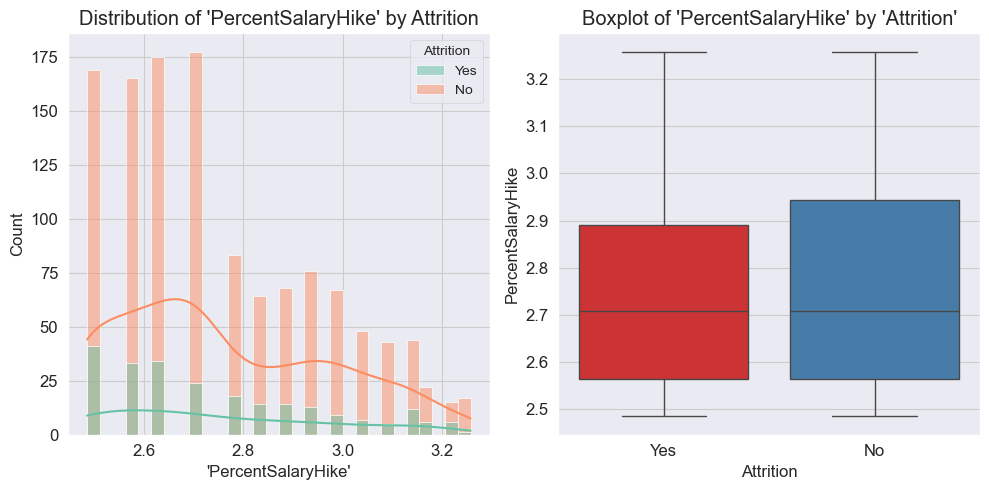

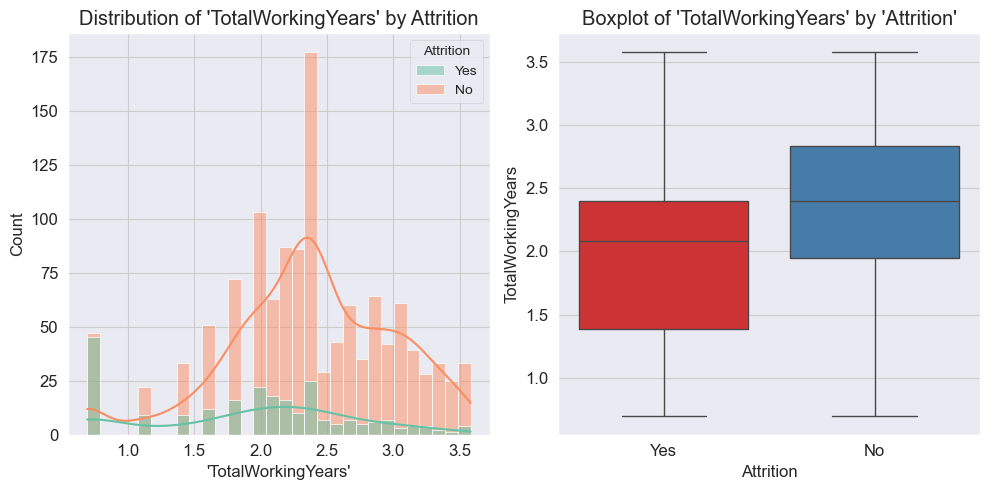

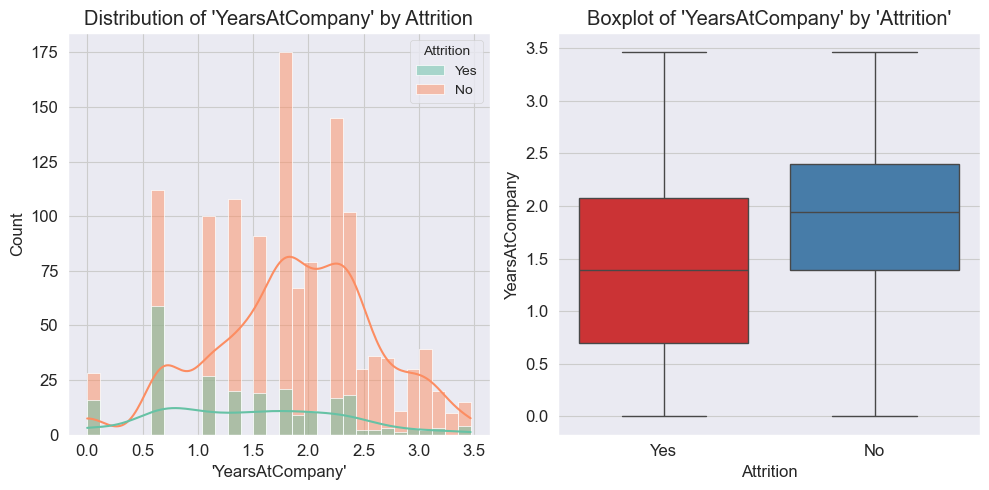

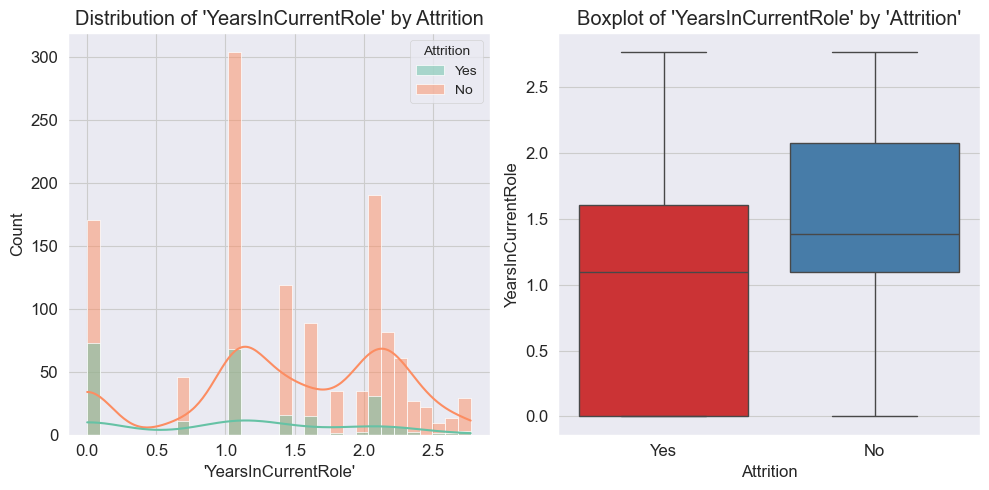

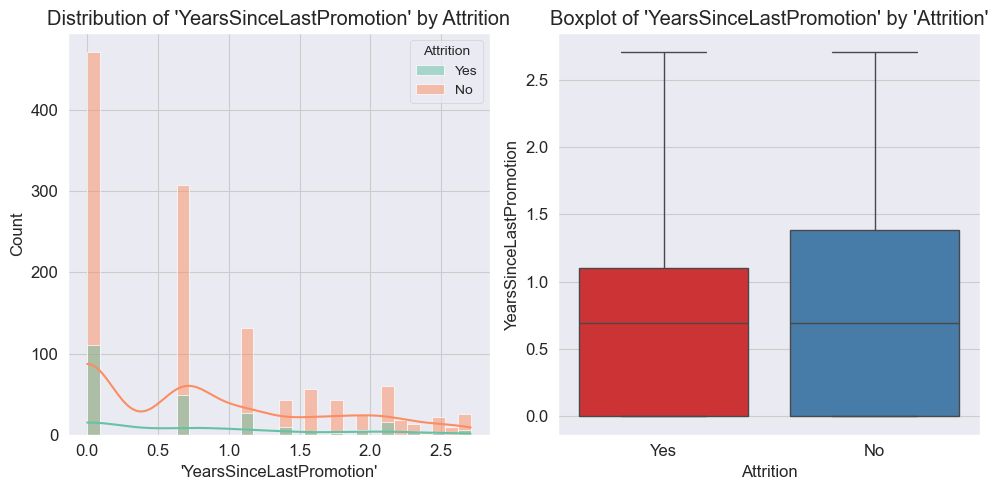

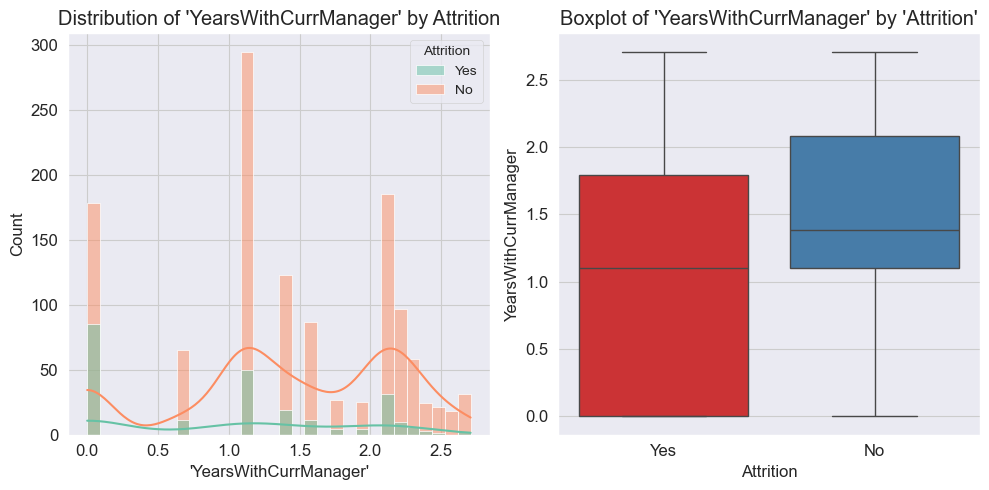

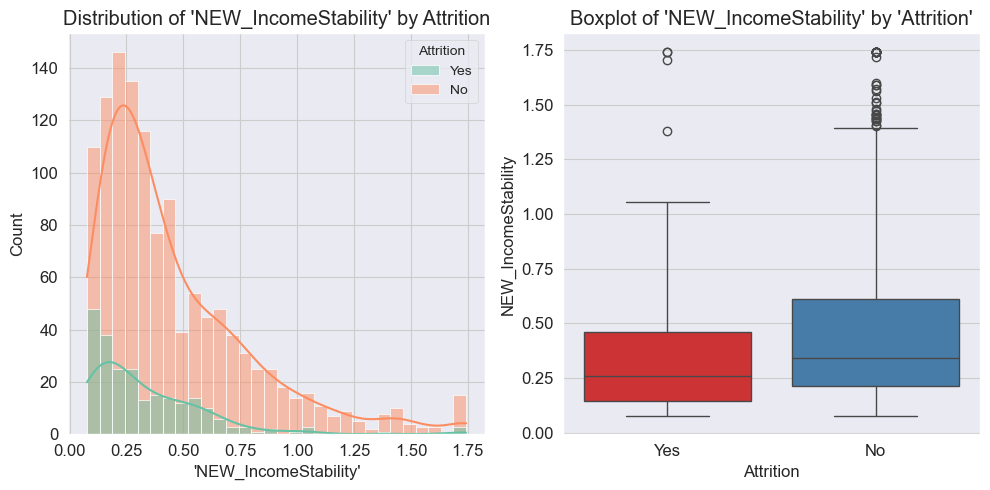

In [12]:
for col in cols_with_high_skew:
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  viz.num_distribution(new_df, col_name=col, hue=target_col, ax=axes[0])
  viz.boxplot_by_target(new_df, target_col, col, ax=axes[1])

  plt.tight_layout()
  plt.show()

## Feature Selection ✍🏻

In [13]:
features_to_remove

['MonthlyIncome']

### Some Quick Preprocessing

#### Encoding Categorical Features

In [14]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder

# Encoding ordinal categorical features
ord_cat_cols = ["OverTime", "BusinessTravel"]
ord_categories = [
  ["Yes", "No"],
  ["Non-Travel", "Travel_Rarely", "Travel_Frequently"]
]

new_df[ord_cat_cols] = OrdinalEncoder(categories=ord_categories).fit_transform(new_df[ord_cat_cols])
new_df[target_col] = LabelEncoder().fit_transform(new_df[target_col])

# Encoding nominal categorical features
nom_cat_cols = ["Department", "EducationField", "Gender", "JobRole", "MaritalStatus", "Over18"]
onehot_encoder = OneHotEncoder(sparse_output=False, drop="if_binary").fit(new_df[nom_cat_cols])
onehot_encoded_features = onehot_encoder.get_feature_names_out(nom_cat_cols)
new_df[onehot_encoded_features] = onehot_encoder.transform(new_df[nom_cat_cols])
new_df.drop(columns=nom_cat_cols, inplace=True)

In [15]:
new_df.head()

,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,NEW_IncomeStability,NEW_OvertimeImpact,NEW_AttritionRiskScore,NEW_FirstJob,NEW_FrequentTraveler,NEW_MarriedWithHighWorkload,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y
0,41,1,1.00,1102,0.69,2,1,1,2,94,3,2,4,19479,8,0.00,2.48,3,1,80,0,2.20,0,1,1.95,1.61,0.00,1.79,0.27,4,5,0,0,0,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00
1,49,0,2.00,279,2.20,1,1,2,3,61,2,2,2,24907,1,1.00,3.18,4,4,80,1,2.40,3,3,2.40,2.08,0.69,2.08,0.19,0,3,0,1,0,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00
2,37,1,1.00,1373,1.10,2,1,4,4,92,2,1,3,2396,6,0.00,2.77,3,2,80,0,2.08,3,3,0.00,0.00,0.00,0.00,0.63,3,4,0,0,0,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00
3,33,0,2.00,1392,1.39,4,1,5,4,56,3,1,3,23159,1,0.00,2.48,3,3,80,0,2.20,3,3,2.20,2.08,1.39,0.00,0.12,3,4,0,1,1,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00
4,27,0,1.00,591,1.10,1,1,7,1,40,3,1,2,16632,9,1.00,2.56,3,4,80,1,1.95,3,3,1.10,1.10,1.10,1.10,0.19,0,3,0,0,0,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00


In [16]:
new_df.describe()

,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,NEW_IncomeStability,NEW_OvertimeImpact,NEW_AttritionRiskScore,NEW_FirstJob,NEW_FrequentTraveler,NEW_MarriedWithHighWorkload,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y
count,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00
mean,36.92,0.16,1.09,802.49,1.98,2.91,1.00,1024.87,2.72,65.89,2.73,2.06,2.73,14313.10,2.69,0.72,2.76,3.15,2.71,80.00,0.79,2.30,2.80,2.76,1.81,1.38,0.79,1.35,0.44,0.78,3.37,0.13,0.19,0.13,0.04,0.65,0.30,0.02,0.41,0.11,0.32,0.06,0.09,0.60,0.09,0.04,0.18,0.07,0.10,0.05,0.20,0.22,0.06,0.22,0.46,0.32,1.00
std,9.14,0.37,0.53,403.51,0.86,1.02,0.00,602.02,1.09,20.33,0.71,1.11,1.10,7117.79,2.50,0.45,0.21,0.36,1.08,0.00,0.85,0.68,1.29,0.71,0.76,0.79,0.81,0.80,0.33,1.38,1.74,0.34,0.39,0.33,0.20,0.48,0.46,0.13,0.49,0.31,0.46,0.23,0.29,0.49,0.29,0.18,0.38,0.25,0.30,0.23,0.40,0.42,0.23,0.42,0.50,0.47,0.00
min,18.00,0.00,0.00,102.00,0.69,1.00,1.00,1.00,1.00,30.00,1.00,1.00,1.00,2094.00,0.00,0.00,2.48,3.00,1.00,80.00,0.00,0.69,0.00,1.00,0.00,0.00,0.00,0.00,0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
25%,30.00,0.00,1.00,465.00,1.10,2.00,1.00,491.25,2.00,48.00,2.00,1.00,2.00,8047.00,1.00,0.00,2.56,3.00,2.00,80.00,0.00,1.95,2.00,2.00,1.39,1.10,0.00,1.10,0.20,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
50%,36.00,0.00,1.00,802.00,2.08,3.00,1.00,1020.50,3.00,66.00,3.00,2.00,3.00,14235.50,2.00,1.00,2.71,3.00,3.00,80.00,1.00,2.40,3.00,3.00,1.79,1.39,0.69,1.39,0.33,0.00,3.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
75%,43.00,0.00,1.00,1157.00,2.71,4.00,1.00,1555.75,4.00,83.75,3.00,3.00,4.00,20461.50,4.00,1.00,2.94,3.00,4.00,80.00,1.00,2.77,3.00,3.00,2.30,2.08,1.39,2.08,0.58,1.00,4.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00
max,60.00,1.00,2.00,1499.00,3.40,5.00,1.00,2068.00,4.00,100.00,4.00,5.00,4.00,26999.00,9.00,1.00,3.26,4.00,4.00,80.00,3.00,3.58,6.00,4.00,3.47,2.77,2.71,2.71,1.74,4.00,9.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


#### Scaling Numeric Features

In [17]:
# Scaling Numeric features
cols_to_scale = [col for col in new_df.columns if new_df[col].nunique() > 2]
scaler = StandardScaler()

new_df[cols_to_scale] = scaler.fit_transform(new_df[cols_to_scale])
new_df.describe()

,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,NEW_IncomeStability,NEW_OvertimeImpact,NEW_AttritionRiskScore,NEW_FirstJob,NEW_FrequentTraveler,NEW_MarriedWithHighWorkload,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y
count,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00
mean,-0.00,0.16,-0.00,0.00,0.00,0.00,1.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.72,0.00,3.15,0.00,80.00,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.13,0.19,0.13,0.04,0.65,0.30,0.02,0.41,0.11,0.32,0.06,0.09,0.60,0.09,0.04,0.18,0.07,0.10,0.05,0.20,0.22,0.06,0.22,0.46,0.32,1.00
std,1.00,0.37,1.00,1.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.45,1.00,0.36,1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.34,0.39,0.33,0.20,0.48,0.46,0.13,0.49,0.31,0.46,0.23,0.29,0.49,0.29,0.18,0.38,0.25,0.30,0.23,0.40,0.42,0.23,0.42,0.50,0.47,0.00
min,-2.07,0.00,-2.04,-1.74,-1.51,-1.87,1.00,-1.70,-1.58,-1.77,-2.43,-0.96,-1.57,-1.72,-1.08,0.00,-1.29,3.00,-1.58,80.00,-0.93,-2.35,-2.17,-2.49,-2.40,-1.74,-0.97,-1.68,-1.09,-0.57,-1.93,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
25%,-0.76,0.00,-0.16,-0.84,-1.03,-0.89,1.00,-0.89,-0.66,-0.88,-1.03,-0.96,-0.66,-0.88,-0.68,0.00,-0.92,3.00,-0.66,80.00,-0.93,-0.52,-0.62,-1.08,-0.56,-0.35,-0.97,-0.31,-0.72,-0.57,-0.78,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
50%,-0.10,0.00,-0.16,-0.00,0.11,0.09,1.00,-0.01,0.25,0.01,0.38,-0.06,0.25,-0.01,-0.28,1.00,-0.25,3.00,0.27,80.00,0.24,0.14,0.16,0.34,-0.03,0.01,-0.12,0.05,-0.31,-0.57,-0.21,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
75%,0.67,0.00,-0.16,0.88,0.85,1.06,1.00,0.88,1.17,0.88,0.38,0.85,1.15,0.86,0.52,1.00,0.85,3.00,1.19,80.00,0.24,0.69,0.16,0.34,0.65,0.89,0.74,0.91,0.42,0.16,0.36,0.00,0.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00
max,2.53,1.00,1.72,1.73,1.66,2.04,1.00,1.73,1.17,1.68,1.79,2.65,1.15,1.78,2.53,1.00,2.32,4.00,1.19,80.00,2.59,1.88,2.48,1.75,2.19,1.76,2.38,1.69,3.92,2.32,3.23,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


### Using `sklearn.feature_selection.SelectKBest` and `f_classif` to evaluate the importance of each feature

In [18]:
len(new_df.columns)

57

In [19]:
from sklearn.feature_selection import SelectKBest, f_classif

X, y = new_df.drop(columns=[target_col]), new_df[target_col]

selector = SelectKBest(f_classif, k="all")
selector.fit(X, y)

feature_scores = pd.DataFrame({
  'Feature': X.columns,
  'Score': selector.scores_
})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)
print(feature_scores)

                              Feature  Score
14                           OverTime  94.66
20                  TotalWorkingYears  82.37
29             NEW_AttritionRiskScore  74.05
23                     YearsAtCompany  60.73
26               YearsWithCurrManager  55.29
24                 YearsInCurrentRole  53.50
28                 NEW_OvertimeImpact  52.55
54               MaritalStatus_Single  46.61
10                           JobLevel  43.22
0                                 Age  38.18
51       JobRole_Sales Representative  37.21
19                   StockOptionLevel  28.14
9                      JobInvolvement  25.24
27                NEW_IncomeStability  24.88
1                      BusinessTravel  24.07
31               NEW_FrequentTraveler  19.72
11                    JobSatisfaction  15.89
7             EnvironmentSatisfaction  15.86
45      JobRole_Laboratory Technician  14.32
53              MaritalStatus_Married  12.25
48          JobRole_Research Director  11.69
52        

In [20]:
features_to_remove.extend(['EmployeeCount', 'StandardHours', 'Over18_Y'])  # features with only one value
features_to_remove.extend(["JobRole_Sales Executive", "EducationField_Other", "PercentSalaryHike", "Department_Human Resources", "HourlyRate", "PerformanceRating", "JobRole_Research Scientist"])  # features with low importance
features_to_remove.append("EmployeeNumber")  # Employee ID which doesn't add any meaning
features_to_remove

['MonthlyIncome',
 'EmployeeCount',
 'StandardHours',
 'Over18_Y',
 'JobRole_Sales Executive',
 'EducationField_Other',
 'PercentSalaryHike',
 'Department_Human Resources',
 'HourlyRate',
 'PerformanceRating',
 'JobRole_Research Scientist',
 'EmployeeNumber']